### Task 3: Customer Segmentation Using RFM Analysis 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### STEP 1: Load Dataset

In [7]:
df = pd.read_csv("online_retail.csv")
print("Columns in dataset:", df.columns.tolist())

Columns in dataset: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'CustomerID', 'Country']


#### STEP 2: Data Cleaning

In [8]:
# Standardize column names (remove spaces, lowercase for safety)
df.columns = df.columns.str.strip().str.lower()

# Check again
print("Standardized columns:", df.columns.tolist())

# Now we expect 'customerid' instead of 'CustomerID'
if 'customerid' not in df.columns:
    raise KeyError("Column 'CustomerID' not found. Available columns: " + str(df.columns.tolist()))

# Ensure CustomerID column is treated as string
df['customerid'] = df['customerid'].astype(str)

# Drop missing CustomerID
df = df[df['customerid'].notna() & (df['customerid'] != '')]

# Remove canceled orders (InvoiceNo starting with 'C')
df = df[~df['invoiceno'].astype(str).str.startswith('C')]

# Remove negative/zero quantities and prices
df = df[(df['quantity'] > 0) & (df['price'] > 0)]

# Convert InvoiceDate to datetime
df['invoicedate'] = pd.to_datetime(df['invoicedate'])

# Create TotalPrice
df['totalprice'] = df['quantity'] * df['price']



Standardized columns: ['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate', 'price', 'customerid', 'country']


#### STEP 3: RFM Calculation

In [9]:
date_ref = df['invoicedate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('customerid').agg({
    'invoicedate': lambda x: (date_ref - x.max()).days,
    'invoiceno': 'nunique',
    'totalprice': 'sum'
})

rfm.rename(columns={
    'invoicedate': 'Recency',
    'invoiceno': 'Frequency',
    'totalprice': 'Monetary'
}, inplace=True)

#### STEP 4: RFM Scoring

In [13]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

# Convert category scores to int for later use
rfm['R_score'] = rfm['R_score'].astype(int)
rfm['F_score'] = rfm['F_score'].astype(int)
rfm['M_score'] = rfm['M_score'].astype(int)

rfm['RFM_Segment'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].mean(axis=1)


#### STEP 5: Customer Segmentation

In [14]:
def segment_customer(row):
    if row['RFM_Score'] >= 3.5:
        return 'Champions'
    elif row['RFM_Score'] >= 2.5:
        return 'Loyal'
    elif row['RFM_Score'] >= 1.5:
        return 'At Risk'
    else:
        return 'Lost'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)


#### STEP 6: Visualization

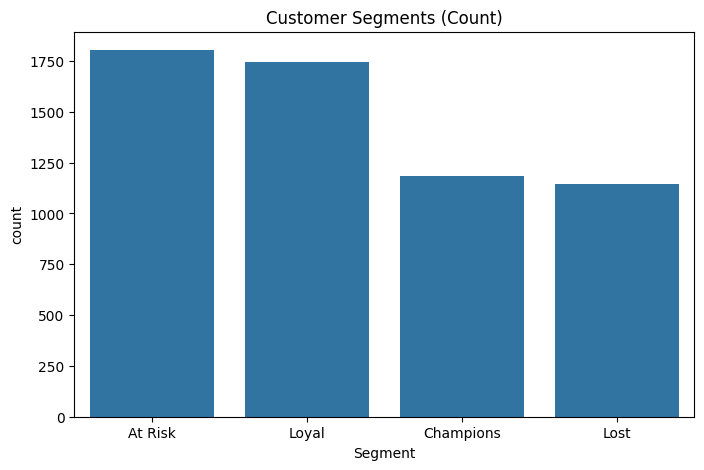

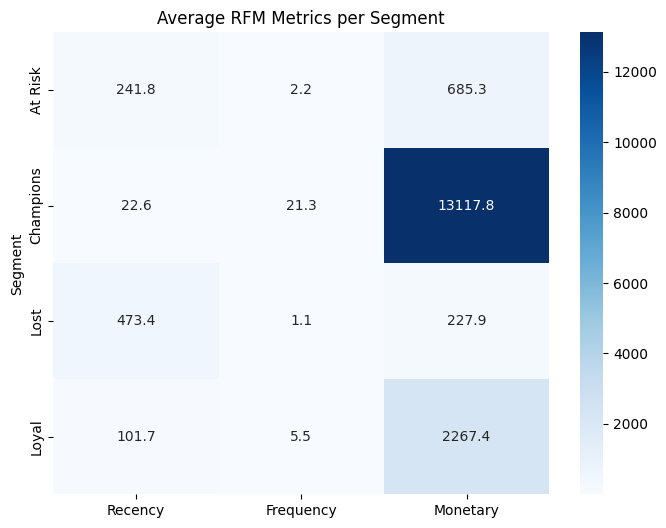

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments (Count)')
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean(), annot=True, fmt='.1f', cmap='Blues')
plt.title('Average RFM Metrics per Segment')
plt.show()


#### STEP 7: Insights

In [16]:
segment_summary = rfm.groupby('Segment').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean','count']
}).round(1)

print("\n--- Segment Summary ---")
print(segment_summary)

rfm.to_csv("rfm_segments.csv", index=True)



--- Segment Summary ---
          Recency Frequency Monetary      
             mean      mean     mean count
Segment                                   
At Risk     241.8       2.2    685.3  1804
Champions    22.6      21.3  13117.8  1183
Lost        473.4       1.1    227.9  1147
Loyal       101.7       5.5   2267.4  1745
